### Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('./MyDrive')

Mounted at ./MyDrive


In [ ]:
cd MyDrive/My Drive/Colab Notebooks/project

/content/MyDrive/My Drive/Colab Notebooks/project


### Package Loading

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split

from torchvision import transforms
from torchvision.datasets import STL10
from torchsummary import summary

from tqdm.notebook import tqdm
import time

### Parameter Setting

In [ ]:
class Config:
    seed = 42
    device = "cuda"if torch.cuda.is_available() else 'cpu'

    epochs = 250
    epochs_fine_training = 25
    batch_size = 50
    n_classes = 10

    lambd = 3
    dim_noise = 100
    image_size = (3, 64, 64)

    d_g_lr = 0.0002
    d_g_beta1 = 0.5

    s_lr = 0.0002
    s_beta1 = 0.5

    g_path = "./checkpoint/meta_pseudo_labels(GAN)/Generator(Xception).pt"
    d_path = "./checkpoint/meta_pseudo_labels(GAN)/Discriminator(Xception).pt"
    s_path = "./checkpoint/meta_pseudo_labels(GAN)/Student(Xception).pt"
    s_fine_training_path = "./checkpoint/meta_pseudo_labels(GAN)/Student_fine_trained(Xception).pt"

    history_path = "./history/meta_pseudo_labels(GAN)/history(Xception).csv"
    history_fine_training_path = "./history/meta_pseudo_labels(GAN)/history_fine_training(Xception).csv"

print(Config.device)

cuda


In [ ]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = True 

In [ ]:
seed_everything(Config.seed)

### Data Loading

In [ ]:
transform = transforms.Compose([transforms.RandomCrop((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

In [ ]:
train_ds = STL10('./data', split='train', download=True, transform=transform)
unlabeled_ds = STL10('./data', split='unlabeled', download=True, transform=transform)
test_ds = STL10('./data', split='test', download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set, valid_set = random_split(train_ds, [4000, 1000])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


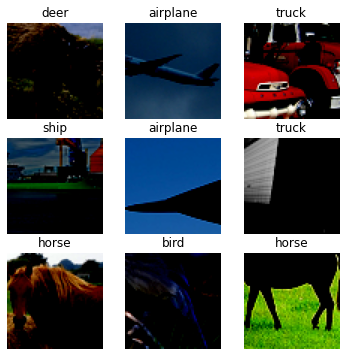

In [ ]:
figure = plt.figure(figsize=(6, 6))

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(classes[label])
    plt.axis("off")
    plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()

In [ ]:
print("labeld size: %d" % (len(train_set)))
print("unlabeld size: %d" % (len(unlabeled_ds)))
print("validation size: %d" % (len(valid_set)))
print("test size: %d" % (len(test_ds)))

labeld size: 4000
unlabeld size: 100000
validation size: 1000
test size: 8000


In [ ]:
labeled_dl = DataLoader(train_set, batch_size=Config.batch_size, shuffle=True)
unlabeled_dl = DataLoader(unlabeled_ds, batch_size=len(train_set), shuffle=True)
valid_dl = DataLoader(valid_set, batch_size=Config.batch_size,)
test_dl = DataLoader(test_ds, batch_size=Config.batch_size)

### Model Defining

Teacher(DCGAN)

In [ ]:
class Generator(nn.Module):
    def __init__(self, dim_noise):
        super(Generator, self).__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(dim_noise, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

        self.initialize_weights()

    def initialize_weights(self):
        for i in self.modules():
          if isinstance(i, nn.ConvTranspose2d):
              nn.init.normal_(i.weight, mean=0.0, std=0.02)
          elif isinstance(i, nn.BatchNorm2d):
              nn.init.normal_(i.weight, mean=1.0, std=0.02)
              nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
        output = self.layers(inputs)

        return output

In [ ]:
g_model = Generator(dim_noise=Config.dim_noise).to(Config.device)

summary(g_model, input_size = (Config.dim_noise, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_classes):
        super(Discriminator, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(512, 10, kernel_size=4, stride=1, padding=0, bias=False),
        )

        self.softmax = nn.Softmax(-1)


        self.initialize_weights()

    def initialize_weights(self):
        for i in self.modules():
          if isinstance(i, nn.Conv2d):
              nn.init.normal_(i.weight, mean=0.0, std=0.02)
          elif isinstance(i, nn.BatchNorm2d):
              nn.init.normal_(i.weight, mean=1.0, std=0.02)
              nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
        x = self.layers(inputs)
        x = x.view(x.shape[0], -1)
        outputs = self.softmax(x)
        return outputs

In [ ]:
d_model = Discriminator(n_classes=Config.n_classes).to(Config.device)

summary(d_model, input_size = Config.image_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
       BatchNorm2d-2           [-1, 64, 32, 32]             128
         LeakyReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]         131,072
       BatchNorm2d-5          [-1, 128, 16, 16]             256
         LeakyReLU-6          [-1, 128, 16, 16]               0
            Conv2d-7            [-1, 256, 8, 8]         524,288
       BatchNorm2d-8            [-1, 256, 8, 8]             512
         LeakyReLU-9            [-1, 256, 8, 8]               0
           Conv2d-10            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
        LeakyReLU-12            [-1, 512, 4, 4]               0
           Conv2d-13             [-1, 10, 1, 1]          81,920
          Softmax-14                   

Student(Xception)

In [ ]:
class ConvWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)

        return outputs

In [ ]:
class SeparableConvWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SeparableConvWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1, groups=in_channels, bias=False),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)
        
        return outputs

In [ ]:
class ShortcutProjectionWithBN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ShortcutProjectionWithBN, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, inputs):
        outputs = self.layers(inputs)

        return outputs

In [ ]:
class EntryFlow(nn.Module):
    def __init__(self):
        super(EntryFlow, self).__init__()

        self.block_1 = nn.Sequential(
            ConvWithBN(3, 32),
            nn.ReLU(),
            ConvWithBN(32, 64),
            nn.ReLU()
        )

        self.block_2 = nn.Sequential(
            SeparableConvWithBN(64, 128),
            nn.ReLU(),
            SeparableConvWithBN(128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_2_shortcut = ShortcutProjectionWithBN(64, 128)

        self.block_3 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(128, 256),
            nn.ReLU(),
            SeparableConvWithBN(256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_3_shortcut = ShortcutProjectionWithBN(128, 256)

        self.block_4 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(256, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_4_shortcut = ShortcutProjectionWithBN(256, 728)

    def forward(self, inputs):
        x = self.block_1(inputs)
        x = self.block_2(x) + self.block_2_shortcut(x)
        x = self.block_3(x) + self.block_3_shortcut(x)
        outputs = self.block_4(x) + self.block_4_shortcut(x)
        
        return outputs

In [ ]:
class MiddleFlow(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
        )

    def forward(self, inputs):
        outputs = self.layers(inputs) + inputs

        return outputs

In [ ]:
class ExitFlow(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.ReLU(),
            SeparableConvWithBN(728, 728),
            nn.ReLU(),
            SeparableConvWithBN(728, 1024),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.block_1_shortcut = ShortcutProjectionWithBN(728, 1024)

        self.block_2 = nn.Sequential(
            SeparableConvWithBN(1024, 1536),
            nn.ReLU(),
            SeparableConvWithBN(1536, 2048),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 4, stride = 1),
        )
    
    def forward(self, inputs):
        x = self.block_1(inputs) + self.block_1_shortcut(inputs)
        outputs = self.block_2(x)

        return outputs

In [ ]:
class Xception(nn.Module):
    def __init__(self, n_classes):
        super(Xception, self).__init__()

        self.entry_flow = EntryFlow()
        self.middle_flow = self.make_middle_flow()
        self.exit_flow = ExitFlow() 

        self.classifier = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(2048, n_classes)
        )

        self.initialize_weights()

    def make_middle_flow(self):
        outputs = []

        for i in range(8):
            outputs.append(MiddleFlow())

        return nn.Sequential(*outputs)

    def initialize_weights(self):
      for i in self.modules():
        if isinstance(i, nn.Conv2d):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
        elif isinstance(i, nn.Linear):
            nn.init.kaiming_normal_(i.weight, mode='fan_in', nonlinearity='relu')
            nn.init.constant_(i.bias, 0)

    def forward(self, inputs):
      x = self.entry_flow(inputs)
      x = self.middle_flow(x)
      x = self.exit_flow(x)
      x = x.view(x.shape[0], -1)
      outputs = self.classifier(x)
        
      return outputs

In [ ]:
s_model = Xception(n_classes=Config.n_classes).to(Config.device)

summary(s_model, input_size = (Config.image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
       BatchNorm2d-2           [-1, 32, 64, 64]              64
        ConvWithBN-3           [-1, 32, 64, 64]               0
              ReLU-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,432
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        ConvWithBN-7           [-1, 64, 64, 64]               0
              ReLU-8           [-1, 64, 64, 64]               0
            Conv2d-9           [-1, 64, 64, 64]             576
           Conv2d-10          [-1, 128, 64, 64]           8,192
      BatchNorm2d-11          [-1, 128, 64, 64]             256
SeparableConvWithBN-12          [-1, 128, 64, 64]               0
             ReLU-13          [-1, 128, 64, 64]               0
           Conv2d-14          [-1, 12

### Training Setting

In [ ]:
class MarginalHLoss(nn.Module):
  def __init__(self):
    super(MarginalHLoss, self).__init__()

  def forward(self, x):
    x = x.mean(axis=0)
    x = -torch.sum(x*torch.log(x+1e-6))
    
    return x

In [ ]:
class JointHLoss(nn.Module):
  def __init__(self):
    super(JointHLoss, self).__init__()

  def forward(self, x):
    x = -x*torch.log(x+1e-6)
    x = 1.0/Config.batch_size*x.sum()
    
    return x

In [ ]:
cross_entropy = nn.CrossEntropyLoss(reduction='mean')
marginal_entropy = MarginalHLoss()
joint_entropy = JointHLoss()

d_optimizer = optim.Adam(d_model.parameters(), lr=Config.d_g_lr, betas=(Config.d_g_beta1, 0.999))
g_optimizer = optim.Adam(g_model.parameters(), lr=Config.d_g_lr, betas=(Config.d_g_beta1, 0.999))
s_optimizer = optim.Adam(s_model.parameters(), lr=Config.s_lr, betas=(Config.s_beta1, 0.999))

In [ ]:
def meta_pseudo_labels(g_model, d_model, s_model, g_optimizer, d_optimizer, s_optimizer, lambd, epochs, g_path, d_path, s_path, history_path, labeled_dl, unlabeled_dl, valid_dl):
    history = {'G_loss':[], 'D_loss':[], 'S_loss':[], 'S_valid_acc':[]}        
    start_time = time.time()

    current_label_epoch = 0;
      
    for unlabel_iter in range(int(epochs/len(unlabeled_dl))): 
        for unlabeled_batch, _ in unlabeled_dl:
            epoch_time = time.time()

            total_G_loss = 0
            total_D_loss = 0
            total_S_loss = 0

            s_model.train()
            for (labeled_inputs, labels), i in tqdm(zip(labeled_dl, range(len(labeled_dl))), total=len(labeled_dl), desc="Training", leave=False):
                labeled_inputs, labels = labeled_inputs.to(Config.device), labels.to(Config.device)
                unlabeled_inputs = unlabeled_batch[i*Config.batch_size:(i+1)*Config.batch_size].to(Config.device)

                d_unlabeled_outputs = d_model(unlabeled_inputs)
                _, pseudo_labels = torch.max(d_unlabeled_outputs.detach().data, 1)

                noise = torch.randn(Config.batch_size, Config.dim_noise, 1, 1).to(Config.device)
                fake_inputs = g_model(noise)

                # Train s_model
                s_optimizer.zero_grad()

                s_unlabeled_outputs = s_model(unlabeled_inputs)
                s_labeled_outputs_old = s_model(labeled_inputs)

                s_cross_entropy_unlabeled = cross_entropy(s_unlabeled_outputs, pseudo_labels)

                s_loss = s_cross_entropy_unlabeled
                s_loss.backward(retain_graph=True)
                s_optimizer.step()

                total_S_loss += s_loss.item()

                # Train d_model
                d_optimizer.zero_grad()

                d_labeled_outputs = d_model(labeled_inputs)
                d_fake_outputs = d_model(fake_inputs.detach())

                s_labeled_outputs_new = s_model(labeled_inputs)
                s_cross_entropy_labeled_old = cross_entropy(s_labeled_outputs_old.detach(), labels)
                s_cross_entropy_labeled_new = cross_entropy(s_labeled_outputs_new.detach(), labels)
                coefficient_from_s = s_cross_entropy_labeled_old - s_cross_entropy_labeled_new

                d_cross_entropy_unlabeled = cross_entropy(d_unlabeled_outputs, pseudo_labels)
                d_cross_entropy_labeled = cross_entropy(d_labeled_outputs, labels) 
                d_joint_entropy_fake = joint_entropy(d_fake_outputs) 
                d_marginal_entropy_unlabeled = marginal_entropy(d_unlabeled_outputs)

                d_loss = (coefficient_from_s * d_cross_entropy_unlabeled) + (lambd * d_cross_entropy_labeled) - d_joint_entropy_fake - d_marginal_entropy_unlabeled
                d_loss.backward(retain_graph=True)
                d_optimizer.step()

                total_D_loss += d_loss.item()

                # Train g_model
                g_optimizer.zero_grad()

                d_outputs = d_model(fake_inputs)

                g_joint_entropy = joint_entropy(d_outputs)
                g_marginal_entropy = marginal_entropy(d_outputs)

                g_loss = g_joint_entropy - g_marginal_entropy
                g_loss.backward(retain_graph=True)
                g_optimizer.step()

                total_G_loss += g_loss.item()

            G_loss = total_G_loss / len(labeled_dl)
            D_loss = total_D_loss / len(labeled_dl)
            S_loss = total_S_loss / len(labeled_dl)

            history['G_loss'].append(G_loss)
            history['D_loss'].append(D_loss)
            history['S_loss'].append(S_loss)

            valid_total = 0
            valid_correct = 0

            s_model.eval()
            with torch.no_grad():
              for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
                  inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                  outputs = s_model(inputs)
                  _, predicted = torch.max(outputs.data, 1)

                  valid_total += labels.size(0)
                  valid_correct += (predicted == labels).sum().item()

            valid_acc = valid_correct / valid_total * 100

            history['S_valid_acc'].append(valid_acc)

            current_label_epoch += 1
            tqdm.write('[Epoch : %d/%d] G_loss: %.5f, D_loss: %.5f, S_loss: %.5f, S_valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (current_label_epoch, epochs, G_loss, D_loss, S_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

            torch.save(g_model.state_dict(), g_path)
            torch.save(d_model.state_dict(), d_path)
            torch.save(s_model.state_dict(), s_path)

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return g_model, d_model, s_model, history

In [ ]:
def fine_training(model, optimizer, epochs, model_path, history_path, train_dl, valid_dl):
    history = {'train_loss':[], 'valid_acc':[]}        
    start_time = time.time()
      
    for epoch in range(epochs): 
        epoch_time = time.time()

        train_losses = 0

        valid_total = 0
        valid_correct = 0

        model.train()
        for inputs, labels in tqdm(train_dl, desc="Training", leave=False):
                inputs, labels = inputs.to(Config.device), labels.to(Config.device)
                optimizer.zero_grad()

                outputs = model(inputs)
                cross_entropy_loss = cross_entropy(outputs, labels)

                loss = cross_entropy_loss
                loss.backward(retain_graph=True)
                optimizer.step()

                train_losses += loss.item()

        train_loss = train_losses / len(train_dl)
        history['train_loss'].append(train_loss)

        model.eval()
        with torch.no_grad():
          for inputs, labels in tqdm(valid_dl, desc="Validation", leave=False):
              inputs, labels = inputs.to(Config.device), labels.to(Config.device)

              outputs = model(inputs)
              _, predicted = torch.max(outputs.data, 1)

              valid_total += labels.size(0)
              valid_correct += (predicted == labels).sum().item()


        valid_acc = valid_correct / valid_total * 100
        history['valid_acc'].append(valid_acc)

        tqdm.write('[Epoch : %d/%d] train_loss: %.5f, valid_acc: %.2f, elapsed_time_in_epoch: %02d:%02d' % (epoch + 1, epochs, train_loss, valid_acc, (time.time()-epoch_time)/60, (time.time()-epoch_time)%60))

        torch.save(model.state_dict(), model_path)

    print('Finished training')
    print('Total elapsed time: %02d:%02d' % ((time.time()-start_time)/60, (time.time()-start_time)%60))

    history_df = pd.DataFrame(history)
    history_df.to_csv(history_path)

    return model, history

### Meta Pseudo Labels

In [ ]:
g_model, d_model, s_model, history = meta_pseudo_labels(g_model, d_model, s_model, g_optimizer, d_optimizer, s_optimizer, Config.lambd, Config.epochs, Config.g_path, Config.d_path, Config.s_path, Config.history_path, labeled_dl, unlabeled_dl, valid_dl)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 1/250] G_loss: -0.34587, D_loss: 2.77866, S_loss: 1.79182, S_valid_acc: 26.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 2/250] G_loss: -0.29380, D_loss: 2.49013, S_loss: 1.42896, S_valid_acc: 32.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 3/250] G_loss: -0.21840, D_loss: 2.24743, S_loss: 1.30180, S_valid_acc: 33.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 4/250] G_loss: -0.16752, D_loss: 2.14718, S_loss: 1.19980, S_valid_acc: 34.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 5/250] G_loss: -0.14606, D_loss: 2.01261, S_loss: 1.15282, S_valid_acc: 34.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 6/250] G_loss: -0.13578, D_loss: 1.98582, S_loss: 1.06929, S_valid_acc: 37.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 7/250] G_loss: -0.13583, D_loss: 1.85793, S_loss: 1.04525, S_valid_acc: 38.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 8/250] G_loss: -0.14310, D_loss: 1.92682, S_loss: 1.08257, S_valid_acc: 37.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 9/250] G_loss: -0.16806, D_loss: 2.01849, S_loss: 1.24033, S_valid_acc: 41.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 10/250] G_loss: -0.16079, D_loss: 1.98942, S_loss: 1.22271, S_valid_acc: 38.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 11/250] G_loss: -0.14805, D_loss: 1.94299, S_loss: 1.15012, S_valid_acc: 40.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 12/250] G_loss: -0.14999, D_loss: 1.98645, S_loss: 1.16413, S_valid_acc: 39.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 13/250] G_loss: -0.15192, D_loss: 1.94835, S_loss: 1.22710, S_valid_acc: 42.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 14/250] G_loss: -0.15698, D_loss: 1.90884, S_loss: 1.17393, S_valid_acc: 41.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 15/250] G_loss: -0.14371, D_loss: 1.81431, S_loss: 1.10798, S_valid_acc: 40.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 16/250] G_loss: -0.15062, D_loss: 1.84096, S_loss: 1.13645, S_valid_acc: 43.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 17/250] G_loss: -0.14598, D_loss: 1.81561, S_loss: 1.10846, S_valid_acc: 47.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 18/250] G_loss: -0.15256, D_loss: 1.80739, S_loss: 1.11869, S_valid_acc: 44.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 19/250] G_loss: -0.14650, D_loss: 1.71073, S_loss: 1.11094, S_valid_acc: 44.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 20/250] G_loss: -0.14463, D_loss: 1.74440, S_loss: 1.08043, S_valid_acc: 47.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 21/250] G_loss: -0.14060, D_loss: 1.71188, S_loss: 1.10386, S_valid_acc: 46.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 22/250] G_loss: -0.14367, D_loss: 1.68077, S_loss: 1.09014, S_valid_acc: 47.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 23/250] G_loss: -0.14491, D_loss: 1.65650, S_loss: 1.14653, S_valid_acc: 47.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 24/250] G_loss: -0.13691, D_loss: 1.60463, S_loss: 1.06289, S_valid_acc: 45.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 25/250] G_loss: -0.14144, D_loss: 1.64782, S_loss: 1.06776, S_valid_acc: 48.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 26/250] G_loss: -0.15548, D_loss: 1.63280, S_loss: 1.09002, S_valid_acc: 48.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 27/250] G_loss: -0.14543, D_loss: 1.60270, S_loss: 1.06605, S_valid_acc: 49.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 28/250] G_loss: -0.13888, D_loss: 1.52731, S_loss: 1.01341, S_valid_acc: 45.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 29/250] G_loss: -0.13978, D_loss: 1.50342, S_loss: 0.98171, S_valid_acc: 51.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 30/250] G_loss: -0.13717, D_loss: 1.53306, S_loss: 0.98633, S_valid_acc: 50.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 31/250] G_loss: -0.13976, D_loss: 1.50411, S_loss: 0.97654, S_valid_acc: 48.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 32/250] G_loss: -0.13551, D_loss: 1.50848, S_loss: 1.00306, S_valid_acc: 51.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 33/250] G_loss: -0.13602, D_loss: 1.50418, S_loss: 0.98283, S_valid_acc: 51.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 34/250] G_loss: -0.13771, D_loss: 1.48123, S_loss: 0.99743, S_valid_acc: 52.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 35/250] G_loss: -0.14263, D_loss: 1.45609, S_loss: 1.02939, S_valid_acc: 52.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 36/250] G_loss: -0.13948, D_loss: 1.49154, S_loss: 1.00513, S_valid_acc: 52.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 37/250] G_loss: -0.14294, D_loss: 1.46747, S_loss: 0.99670, S_valid_acc: 51.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 38/250] G_loss: -0.14196, D_loss: 1.42874, S_loss: 0.99155, S_valid_acc: 50.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 39/250] G_loss: -0.14124, D_loss: 1.44057, S_loss: 0.98077, S_valid_acc: 51.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 40/250] G_loss: -0.14787, D_loss: 1.43761, S_loss: 0.99511, S_valid_acc: 53.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 41/250] G_loss: -0.14581, D_loss: 1.43940, S_loss: 0.96347, S_valid_acc: 53.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 42/250] G_loss: -0.13781, D_loss: 1.39841, S_loss: 0.94585, S_valid_acc: 53.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 43/250] G_loss: -0.13451, D_loss: 1.38418, S_loss: 0.95406, S_valid_acc: 52.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 44/250] G_loss: -0.14837, D_loss: 1.45292, S_loss: 1.02306, S_valid_acc: 53.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 45/250] G_loss: -0.13747, D_loss: 1.37991, S_loss: 0.94935, S_valid_acc: 54.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 46/250] G_loss: -0.14997, D_loss: 1.44180, S_loss: 1.01130, S_valid_acc: 53.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 47/250] G_loss: -0.14581, D_loss: 1.35132, S_loss: 0.96846, S_valid_acc: 52.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 48/250] G_loss: -0.15483, D_loss: 1.40858, S_loss: 0.98043, S_valid_acc: 53.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 49/250] G_loss: -0.14576, D_loss: 1.37855, S_loss: 0.96224, S_valid_acc: 53.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 50/250] G_loss: -0.14956, D_loss: 1.39351, S_loss: 0.97508, S_valid_acc: 54.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 51/250] G_loss: -0.14796, D_loss: 1.35032, S_loss: 0.93491, S_valid_acc: 57.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 52/250] G_loss: -0.14071, D_loss: 1.33825, S_loss: 0.91875, S_valid_acc: 55.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 53/250] G_loss: -0.13770, D_loss: 1.30399, S_loss: 0.92274, S_valid_acc: 56.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 54/250] G_loss: -0.15118, D_loss: 1.36745, S_loss: 0.97315, S_valid_acc: 56.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 55/250] G_loss: -0.15077, D_loss: 1.33040, S_loss: 0.94079, S_valid_acc: 52.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 56/250] G_loss: -0.13872, D_loss: 1.27511, S_loss: 0.90830, S_valid_acc: 55.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 57/250] G_loss: -0.14428, D_loss: 1.26251, S_loss: 0.91477, S_valid_acc: 56.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 58/250] G_loss: -0.14056, D_loss: 1.25172, S_loss: 0.89461, S_valid_acc: 54.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 59/250] G_loss: -0.13253, D_loss: 1.22793, S_loss: 0.89731, S_valid_acc: 55.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 60/250] G_loss: -0.13163, D_loss: 1.23136, S_loss: 0.90063, S_valid_acc: 53.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 61/250] G_loss: -0.14041, D_loss: 1.24741, S_loss: 0.91653, S_valid_acc: 57.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 62/250] G_loss: -0.13542, D_loss: 1.23432, S_loss: 0.88873, S_valid_acc: 56.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 63/250] G_loss: -0.12984, D_loss: 1.20662, S_loss: 0.89820, S_valid_acc: 55.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 64/250] G_loss: -0.13606, D_loss: 1.20289, S_loss: 0.92766, S_valid_acc: 56.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 65/250] G_loss: -0.13582, D_loss: 1.19320, S_loss: 0.88807, S_valid_acc: 57.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 66/250] G_loss: -0.13557, D_loss: 1.20711, S_loss: 0.88012, S_valid_acc: 58.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 67/250] G_loss: -0.13576, D_loss: 1.18421, S_loss: 0.89299, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 68/250] G_loss: -0.14113, D_loss: 1.18228, S_loss: 0.90548, S_valid_acc: 57.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 69/250] G_loss: -0.13713, D_loss: 1.18687, S_loss: 0.88100, S_valid_acc: 55.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 70/250] G_loss: -0.14119, D_loss: 1.21485, S_loss: 0.92990, S_valid_acc: 58.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 71/250] G_loss: -0.13597, D_loss: 1.14501, S_loss: 0.89438, S_valid_acc: 56.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 72/250] G_loss: -0.12954, D_loss: 1.17171, S_loss: 0.91620, S_valid_acc: 57.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 73/250] G_loss: -0.13056, D_loss: 1.13231, S_loss: 0.90999, S_valid_acc: 58.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 74/250] G_loss: -0.13668, D_loss: 1.16775, S_loss: 0.91730, S_valid_acc: 59.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 75/250] G_loss: -0.13512, D_loss: 1.15360, S_loss: 0.87034, S_valid_acc: 58.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 76/250] G_loss: -0.13278, D_loss: 1.12817, S_loss: 0.89776, S_valid_acc: 59.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 77/250] G_loss: -0.13110, D_loss: 1.09583, S_loss: 0.88597, S_valid_acc: 60.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 78/250] G_loss: -0.13559, D_loss: 1.09799, S_loss: 0.87438, S_valid_acc: 60.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 79/250] G_loss: -0.13036, D_loss: 1.11064, S_loss: 0.88084, S_valid_acc: 59.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 80/250] G_loss: -0.14014, D_loss: 1.09414, S_loss: 0.90413, S_valid_acc: 60.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 81/250] G_loss: -0.13109, D_loss: 1.08747, S_loss: 0.88414, S_valid_acc: 58.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 82/250] G_loss: -0.13578, D_loss: 1.09842, S_loss: 0.88804, S_valid_acc: 58.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 83/250] G_loss: -0.12808, D_loss: 1.06020, S_loss: 0.87949, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 84/250] G_loss: -0.12841, D_loss: 1.04880, S_loss: 0.87337, S_valid_acc: 59.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 85/250] G_loss: -0.13175, D_loss: 1.12328, S_loss: 0.89632, S_valid_acc: 60.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 86/250] G_loss: -0.12833, D_loss: 1.06242, S_loss: 0.85382, S_valid_acc: 60.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 87/250] G_loss: -0.13081, D_loss: 1.06831, S_loss: 0.86354, S_valid_acc: 59.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 88/250] G_loss: -0.12805, D_loss: 1.05122, S_loss: 0.85834, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 89/250] G_loss: -0.13076, D_loss: 1.05604, S_loss: 0.87660, S_valid_acc: 58.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 90/250] G_loss: -0.12360, D_loss: 0.98113, S_loss: 0.81990, S_valid_acc: 59.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 91/250] G_loss: -0.12539, D_loss: 1.01116, S_loss: 0.85280, S_valid_acc: 59.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 92/250] G_loss: -0.13462, D_loss: 1.03592, S_loss: 0.88895, S_valid_acc: 60.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 93/250] G_loss: -0.13266, D_loss: 1.03802, S_loss: 0.87453, S_valid_acc: 58.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 94/250] G_loss: -0.12662, D_loss: 1.02708, S_loss: 0.83043, S_valid_acc: 62.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 95/250] G_loss: -0.13068, D_loss: 0.99585, S_loss: 0.83965, S_valid_acc: 60.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 96/250] G_loss: -0.13144, D_loss: 0.98340, S_loss: 0.88253, S_valid_acc: 59.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 97/250] G_loss: -0.13156, D_loss: 1.00915, S_loss: 0.88824, S_valid_acc: 61.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 98/250] G_loss: -0.12535, D_loss: 0.97448, S_loss: 0.84354, S_valid_acc: 61.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 99/250] G_loss: -0.12583, D_loss: 0.95097, S_loss: 0.84186, S_valid_acc: 62.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 100/250] G_loss: -0.13303, D_loss: 0.97415, S_loss: 0.86099, S_valid_acc: 60.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 101/250] G_loss: -0.12645, D_loss: 0.96410, S_loss: 0.86453, S_valid_acc: 59.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 102/250] G_loss: -0.13456, D_loss: 1.00008, S_loss: 0.84573, S_valid_acc: 61.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 103/250] G_loss: -0.12382, D_loss: 0.95485, S_loss: 0.85033, S_valid_acc: 61.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 104/250] G_loss: -0.13198, D_loss: 0.95568, S_loss: 0.86765, S_valid_acc: 61.10, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 105/250] G_loss: -0.13168, D_loss: 0.96908, S_loss: 0.86079, S_valid_acc: 60.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 106/250] G_loss: -0.13186, D_loss: 0.92729, S_loss: 0.87605, S_valid_acc: 61.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 107/250] G_loss: -0.12754, D_loss: 0.94256, S_loss: 0.84515, S_valid_acc: 61.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 108/250] G_loss: -0.12589, D_loss: 0.92898, S_loss: 0.83551, S_valid_acc: 61.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 109/250] G_loss: -0.12350, D_loss: 0.92798, S_loss: 0.87288, S_valid_acc: 61.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 110/250] G_loss: -0.12649, D_loss: 0.91182, S_loss: 0.83346, S_valid_acc: 63.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 111/250] G_loss: -0.12373, D_loss: 0.92089, S_loss: 0.84416, S_valid_acc: 63.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 112/250] G_loss: -0.12757, D_loss: 0.95597, S_loss: 0.87001, S_valid_acc: 62.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 113/250] G_loss: -0.13355, D_loss: 0.92835, S_loss: 0.87141, S_valid_acc: 61.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 114/250] G_loss: -0.11919, D_loss: 0.83454, S_loss: 0.80335, S_valid_acc: 60.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 115/250] G_loss: -0.12578, D_loss: 0.88539, S_loss: 0.82354, S_valid_acc: 63.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 116/250] G_loss: -0.12787, D_loss: 0.87371, S_loss: 0.85641, S_valid_acc: 60.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 117/250] G_loss: -0.12269, D_loss: 0.89545, S_loss: 0.82613, S_valid_acc: 61.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 118/250] G_loss: -0.12669, D_loss: 0.87473, S_loss: 0.88682, S_valid_acc: 63.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 119/250] G_loss: -0.12166, D_loss: 0.86117, S_loss: 0.87887, S_valid_acc: 64.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 120/250] G_loss: -0.11596, D_loss: 0.83459, S_loss: 0.84419, S_valid_acc: 61.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 121/250] G_loss: -0.12130, D_loss: 0.84866, S_loss: 0.81985, S_valid_acc: 64.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 122/250] G_loss: -0.12262, D_loss: 0.87932, S_loss: 0.86665, S_valid_acc: 61.40, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 123/250] G_loss: -0.13569, D_loss: 0.89886, S_loss: 0.86508, S_valid_acc: 61.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 124/250] G_loss: -0.12261, D_loss: 0.83120, S_loss: 0.81549, S_valid_acc: 64.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 125/250] G_loss: -0.11747, D_loss: 0.84240, S_loss: 0.81330, S_valid_acc: 65.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 126/250] G_loss: -0.11977, D_loss: 0.83835, S_loss: 0.81540, S_valid_acc: 64.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 127/250] G_loss: -0.12308, D_loss: 0.84559, S_loss: 0.78637, S_valid_acc: 63.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 128/250] G_loss: -0.12654, D_loss: 0.85262, S_loss: 0.85179, S_valid_acc: 63.20, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 129/250] G_loss: -0.12241, D_loss: 0.82540, S_loss: 0.82308, S_valid_acc: 63.80, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 130/250] G_loss: -0.12820, D_loss: 0.83234, S_loss: 0.80846, S_valid_acc: 63.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 131/250] G_loss: -0.12628, D_loss: 0.84337, S_loss: 0.82586, S_valid_acc: 65.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 132/250] G_loss: -0.11651, D_loss: 0.82133, S_loss: 0.81936, S_valid_acc: 63.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 133/250] G_loss: -0.11753, D_loss: 0.78522, S_loss: 0.84017, S_valid_acc: 63.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 134/250] G_loss: -0.11541, D_loss: 0.79462, S_loss: 0.81390, S_valid_acc: 63.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 135/250] G_loss: -0.12625, D_loss: 0.83789, S_loss: 0.86806, S_valid_acc: 63.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 136/250] G_loss: -0.12446, D_loss: 0.82020, S_loss: 0.85136, S_valid_acc: 63.60, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 137/250] G_loss: -0.12106, D_loss: 0.78231, S_loss: 0.86218, S_valid_acc: 63.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 138/250] G_loss: -0.11929, D_loss: 0.77831, S_loss: 0.84669, S_valid_acc: 64.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 139/250] G_loss: -0.12354, D_loss: 0.77300, S_loss: 0.83460, S_valid_acc: 65.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 140/250] G_loss: -0.11971, D_loss: 0.78200, S_loss: 0.83137, S_valid_acc: 64.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 141/250] G_loss: -0.12161, D_loss: 0.78411, S_loss: 0.84493, S_valid_acc: 64.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 142/250] G_loss: -0.12777, D_loss: 0.77411, S_loss: 0.85013, S_valid_acc: 64.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 143/250] G_loss: -0.11836, D_loss: 0.74025, S_loss: 0.84550, S_valid_acc: 65.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 144/250] G_loss: -0.11905, D_loss: 0.76450, S_loss: 0.82234, S_valid_acc: 64.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 145/250] G_loss: -0.11839, D_loss: 0.75625, S_loss: 0.79617, S_valid_acc: 65.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 146/250] G_loss: -0.12413, D_loss: 0.75519, S_loss: 0.81985, S_valid_acc: 65.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 147/250] G_loss: -0.12346, D_loss: 0.74481, S_loss: 0.83209, S_valid_acc: 64.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 148/250] G_loss: -0.11465, D_loss: 0.73404, S_loss: 0.80624, S_valid_acc: 62.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 149/250] G_loss: -0.12234, D_loss: 0.77200, S_loss: 0.83011, S_valid_acc: 64.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 150/250] G_loss: -0.11768, D_loss: 0.71334, S_loss: 0.81447, S_valid_acc: 65.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 151/250] G_loss: -0.11315, D_loss: 0.70941, S_loss: 0.84592, S_valid_acc: 66.70, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 152/250] G_loss: -0.12088, D_loss: 0.71680, S_loss: 0.86104, S_valid_acc: 65.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 153/250] G_loss: -0.12508, D_loss: 0.75891, S_loss: 0.88045, S_valid_acc: 65.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 154/250] G_loss: -0.11860, D_loss: 0.73554, S_loss: 0.83695, S_valid_acc: 67.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 155/250] G_loss: -0.11688, D_loss: 0.69934, S_loss: 0.81335, S_valid_acc: 67.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 156/250] G_loss: -0.11284, D_loss: 0.68487, S_loss: 0.81486, S_valid_acc: 66.70, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 157/250] G_loss: -0.11669, D_loss: 0.72034, S_loss: 0.81464, S_valid_acc: 66.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 158/250] G_loss: -0.11889, D_loss: 0.70130, S_loss: 0.84184, S_valid_acc: 64.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 159/250] G_loss: -0.11702, D_loss: 0.71440, S_loss: 0.84116, S_valid_acc: 68.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 160/250] G_loss: -0.11612, D_loss: 0.70625, S_loss: 0.82182, S_valid_acc: 66.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 161/250] G_loss: -0.10763, D_loss: 0.68419, S_loss: 0.82410, S_valid_acc: 65.60, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 162/250] G_loss: -0.12537, D_loss: 0.71739, S_loss: 0.83419, S_valid_acc: 65.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 163/250] G_loss: -0.11871, D_loss: 0.68275, S_loss: 0.83003, S_valid_acc: 64.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 164/250] G_loss: -0.11735, D_loss: 0.68002, S_loss: 0.82043, S_valid_acc: 64.70, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 165/250] G_loss: -0.11388, D_loss: 0.64753, S_loss: 0.84979, S_valid_acc: 63.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 166/250] G_loss: -0.11344, D_loss: 0.65624, S_loss: 0.78364, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 167/250] G_loss: -0.11231, D_loss: 0.67960, S_loss: 0.84242, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 168/250] G_loss: -0.11667, D_loss: 0.66733, S_loss: 0.84539, S_valid_acc: 65.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 169/250] G_loss: -0.12412, D_loss: 0.70058, S_loss: 0.85046, S_valid_acc: 65.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 170/250] G_loss: -0.11780, D_loss: 0.66738, S_loss: 0.81546, S_valid_acc: 65.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 171/250] G_loss: -0.11411, D_loss: 0.65243, S_loss: 0.82170, S_valid_acc: 62.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 172/250] G_loss: -0.11352, D_loss: 0.67498, S_loss: 0.81014, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 173/250] G_loss: -0.11803, D_loss: 0.67291, S_loss: 0.83252, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 174/250] G_loss: -0.11453, D_loss: 0.64961, S_loss: 0.82724, S_valid_acc: 63.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 175/250] G_loss: -0.11654, D_loss: 0.63570, S_loss: 0.80827, S_valid_acc: 66.60, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 176/250] G_loss: -0.11862, D_loss: 0.66855, S_loss: 0.87349, S_valid_acc: 65.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 177/250] G_loss: -0.13268, D_loss: 0.70320, S_loss: 0.85239, S_valid_acc: 64.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 178/250] G_loss: -0.11694, D_loss: 0.64002, S_loss: 0.83046, S_valid_acc: 66.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 179/250] G_loss: -0.11902, D_loss: 0.66009, S_loss: 0.80990, S_valid_acc: 64.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 180/250] G_loss: -0.12814, D_loss: 0.67221, S_loss: 0.84236, S_valid_acc: 63.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 181/250] G_loss: -0.12282, D_loss: 0.66462, S_loss: 0.85024, S_valid_acc: 67.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 182/250] G_loss: -0.11617, D_loss: 0.62790, S_loss: 0.81321, S_valid_acc: 67.60, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 183/250] G_loss: -0.10928, D_loss: 0.58640, S_loss: 0.79609, S_valid_acc: 63.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 184/250] G_loss: -0.12471, D_loss: 0.67658, S_loss: 0.88625, S_valid_acc: 65.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 185/250] G_loss: -0.11329, D_loss: 0.63737, S_loss: 0.80841, S_valid_acc: 65.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 186/250] G_loss: -0.11718, D_loss: 0.62916, S_loss: 0.80291, S_valid_acc: 66.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 187/250] G_loss: -0.11900, D_loss: 0.61012, S_loss: 0.84744, S_valid_acc: 65.70, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 188/250] G_loss: -0.12017, D_loss: 0.62354, S_loss: 0.84534, S_valid_acc: 67.70, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 189/250] G_loss: -0.11055, D_loss: 0.58539, S_loss: 0.81259, S_valid_acc: 66.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 190/250] G_loss: -0.11845, D_loss: 0.59065, S_loss: 0.84687, S_valid_acc: 66.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 191/250] G_loss: -0.11890, D_loss: 0.60968, S_loss: 0.85868, S_valid_acc: 68.70, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 192/250] G_loss: -0.11959, D_loss: 0.61025, S_loss: 0.83351, S_valid_acc: 67.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 193/250] G_loss: -0.12104, D_loss: 0.60872, S_loss: 0.82680, S_valid_acc: 67.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 194/250] G_loss: -0.11186, D_loss: 0.58208, S_loss: 0.81183, S_valid_acc: 66.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 195/250] G_loss: -0.11033, D_loss: 0.57473, S_loss: 0.83419, S_valid_acc: 66.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 196/250] G_loss: -0.12493, D_loss: 0.61054, S_loss: 0.82968, S_valid_acc: 65.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 197/250] G_loss: -0.11682, D_loss: 0.55816, S_loss: 0.84048, S_valid_acc: 66.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 198/250] G_loss: -0.12594, D_loss: 0.59421, S_loss: 0.86396, S_valid_acc: 67.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 199/250] G_loss: -0.11971, D_loss: 0.58396, S_loss: 0.85905, S_valid_acc: 67.70, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 200/250] G_loss: -0.11853, D_loss: 0.57453, S_loss: 0.81443, S_valid_acc: 65.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 201/250] G_loss: -0.12071, D_loss: 0.58237, S_loss: 0.82419, S_valid_acc: 68.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 202/250] G_loss: -0.11457, D_loss: 0.54190, S_loss: 0.81956, S_valid_acc: 68.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 203/250] G_loss: -0.11482, D_loss: 0.56059, S_loss: 0.81026, S_valid_acc: 67.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 204/250] G_loss: -0.11479, D_loss: 0.56386, S_loss: 0.83132, S_valid_acc: 66.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 205/250] G_loss: -0.11950, D_loss: 0.55904, S_loss: 0.85208, S_valid_acc: 67.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 206/250] G_loss: -0.12268, D_loss: 0.60795, S_loss: 0.85223, S_valid_acc: 66.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 207/250] G_loss: -0.11918, D_loss: 0.58554, S_loss: 0.87041, S_valid_acc: 69.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 208/250] G_loss: -0.11356, D_loss: 0.54655, S_loss: 0.81986, S_valid_acc: 67.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 209/250] G_loss: -0.11901, D_loss: 0.57139, S_loss: 0.86556, S_valid_acc: 65.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 210/250] G_loss: -0.11127, D_loss: 0.53526, S_loss: 0.80911, S_valid_acc: 65.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 211/250] G_loss: -0.11828, D_loss: 0.57892, S_loss: 0.84384, S_valid_acc: 68.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 212/250] G_loss: -0.11579, D_loss: 0.54181, S_loss: 0.82615, S_valid_acc: 67.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 213/250] G_loss: -0.12013, D_loss: 0.56486, S_loss: 0.88374, S_valid_acc: 67.60, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 214/250] G_loss: -0.12006, D_loss: 0.57277, S_loss: 0.84237, S_valid_acc: 68.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 215/250] G_loss: -0.11456, D_loss: 0.52297, S_loss: 0.81181, S_valid_acc: 66.60, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 216/250] G_loss: -0.12102, D_loss: 0.56118, S_loss: 0.80269, S_valid_acc: 67.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 217/250] G_loss: -0.12108, D_loss: 0.55356, S_loss: 0.80867, S_valid_acc: 68.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 218/250] G_loss: -0.12717, D_loss: 0.57130, S_loss: 0.83366, S_valid_acc: 66.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 219/250] G_loss: -0.11861, D_loss: 0.53647, S_loss: 0.85457, S_valid_acc: 66.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 220/250] G_loss: -0.12413, D_loss: 0.55191, S_loss: 0.86857, S_valid_acc: 66.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 221/250] G_loss: -0.11731, D_loss: 0.51228, S_loss: 0.82719, S_valid_acc: 67.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 222/250] G_loss: -0.11681, D_loss: 0.52692, S_loss: 0.85667, S_valid_acc: 68.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 223/250] G_loss: -0.11222, D_loss: 0.52933, S_loss: 0.82461, S_valid_acc: 68.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 224/250] G_loss: -0.11510, D_loss: 0.51434, S_loss: 0.82210, S_valid_acc: 68.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 225/250] G_loss: -0.12356, D_loss: 0.55304, S_loss: 0.87605, S_valid_acc: 66.90, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 226/250] G_loss: -0.11801, D_loss: 0.51761, S_loss: 0.77247, S_valid_acc: 67.10, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 227/250] G_loss: -0.11563, D_loss: 0.50639, S_loss: 0.82362, S_valid_acc: 68.30, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 228/250] G_loss: -0.12176, D_loss: 0.52740, S_loss: 0.84118, S_valid_acc: 68.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 229/250] G_loss: -0.11969, D_loss: 0.51247, S_loss: 0.83693, S_valid_acc: 68.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 230/250] G_loss: -0.11814, D_loss: 0.48655, S_loss: 0.80987, S_valid_acc: 67.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 231/250] G_loss: -0.11998, D_loss: 0.51666, S_loss: 0.85245, S_valid_acc: 67.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 232/250] G_loss: -0.11889, D_loss: 0.52899, S_loss: 0.82719, S_valid_acc: 67.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 233/250] G_loss: -0.12602, D_loss: 0.52329, S_loss: 0.85260, S_valid_acc: 67.50, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 234/250] G_loss: -0.13551, D_loss: 0.55454, S_loss: 0.87513, S_valid_acc: 67.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 235/250] G_loss: -0.11494, D_loss: 0.48092, S_loss: 0.81470, S_valid_acc: 67.00, elapsed_time_in_epoch: 00:28


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 236/250] G_loss: -0.11573, D_loss: 0.46100, S_loss: 0.82949, S_valid_acc: 67.20, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 237/250] G_loss: -0.11816, D_loss: 0.51192, S_loss: 0.86239, S_valid_acc: 67.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 238/250] G_loss: -0.11160, D_loss: 0.44854, S_loss: 0.82649, S_valid_acc: 67.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 239/250] G_loss: -0.11688, D_loss: 0.47030, S_loss: 0.83486, S_valid_acc: 69.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 240/250] G_loss: -0.12461, D_loss: 0.51464, S_loss: 0.85535, S_valid_acc: 66.90, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 241/250] G_loss: -0.12031, D_loss: 0.48976, S_loss: 0.81687, S_valid_acc: 67.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 242/250] G_loss: -0.11785, D_loss: 0.46811, S_loss: 0.81587, S_valid_acc: 68.50, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 243/250] G_loss: -0.11214, D_loss: 0.44531, S_loss: 0.83754, S_valid_acc: 68.60, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 244/250] G_loss: -0.11422, D_loss: 0.46891, S_loss: 0.82489, S_valid_acc: 69.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 245/250] G_loss: -0.11806, D_loss: 0.48264, S_loss: 0.85056, S_valid_acc: 66.30, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 246/250] G_loss: -0.11566, D_loss: 0.45921, S_loss: 0.81395, S_valid_acc: 67.40, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 247/250] G_loss: -0.11321, D_loss: 0.47736, S_loss: 0.83463, S_valid_acc: 68.00, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 248/250] G_loss: -0.11774, D_loss: 0.44981, S_loss: 0.87736, S_valid_acc: 66.80, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 249/250] G_loss: -0.11492, D_loss: 0.46803, S_loss: 0.85076, S_valid_acc: 68.70, elapsed_time_in_epoch: 00:29


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 250/250] G_loss: -0.11127, D_loss: 0.42654, S_loss: 0.82964, S_valid_acc: 67.90, elapsed_time_in_epoch: 00:29
Finished training
Total elapsed time: 130:09


### Fine Training

In [ ]:
s_model.load_state_dict(torch.load(Config.s_path))

<All keys matched successfully>

In [ ]:
s_model, history = fine_training(s_model, s_optimizer, Config.epochs_fine_training, Config.s_fine_training_path, Config.history_fine_training_path, labeled_dl, valid_dl)

Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 1/25] train_loss: 0.63993, valid_acc: 71.40, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 2/25] train_loss: 0.59503, valid_acc: 69.80, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 3/25] train_loss: 0.54000, valid_acc: 69.90, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 4/25] train_loss: 0.50126, valid_acc: 69.90, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 5/25] train_loss: 0.45499, valid_acc: 68.40, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 6/25] train_loss: 0.43433, valid_acc: 68.50, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 7/25] train_loss: 0.38907, valid_acc: 71.60, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 8/25] train_loss: 0.37424, valid_acc: 70.50, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 9/25] train_loss: 0.31161, valid_acc: 69.60, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 10/25] train_loss: 0.27375, valid_acc: 70.00, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 11/25] train_loss: 0.26678, valid_acc: 70.60, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 12/25] train_loss: 0.24481, valid_acc: 71.70, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 13/25] train_loss: 0.19555, valid_acc: 72.00, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 14/25] train_loss: 0.17330, valid_acc: 70.50, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 15/25] train_loss: 0.16378, valid_acc: 71.20, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 16/25] train_loss: 0.17522, valid_acc: 71.10, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 17/25] train_loss: 0.15727, valid_acc: 71.10, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 18/25] train_loss: 0.13465, valid_acc: 70.70, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 19/25] train_loss: 0.11703, valid_acc: 72.00, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 20/25] train_loss: 0.11495, valid_acc: 70.50, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 21/25] train_loss: 0.11250, valid_acc: 69.90, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 22/25] train_loss: 0.09510, valid_acc: 70.90, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 23/25] train_loss: 0.09040, valid_acc: 70.30, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 24/25] train_loss: 0.08011, valid_acc: 70.70, elapsed_time_in_epoch: 00:16


Training:   0%|          | 0/80 [00:00<?, ?it/s]

Validation:   0%|          | 0/20 [00:00<?, ?it/s]

[Epoch : 25/25] train_loss: 0.08317, valid_acc: 69.20, elapsed_time_in_epoch: 00:16
Finished training
Total elapsed time: 07:01


### Testing

In [ ]:
d_model.load_state_dict(torch.load(Config.d_path))

test_total = 0
test_correct = 0

d_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = d_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("d_model test_acc: %.5f" %(test_acc))

d_model test_acc: 68.85000


In [ ]:
s_model.load_state_dict(torch.load(Config.s_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model test_acc: %.5f" %(test_acc))

s_model test_acc: 69.51250


In [ ]:
s_model.load_state_dict(torch.load(Config.s_fine_training_path))

test_total = 0
test_correct = 0

s_model.eval()
with torch.no_grad():
    for inputs, labels in test_dl:
        inputs, labels = inputs.to(Config.device), labels.to(Config.device)
        outputs = s_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total * 100
print("s_model_fine_trained test_acc: %.5f" %(test_acc))

s_model_fine_trained test_acc: 72.72500
